TODO's:
- Upload utility script somewhere, then have notebook fetch it (if it doesn't exist locally).
- Check Classifier performane on GPU (after tokenize moved to .foward). Does x need to be sent to device?
- Classifier save/load (inc. classifier trained on all data)


# ODSC 2022: An Introduction to Drift Detection

## Introduction




## 0. Getting ready



### Software

In this workshop we'll make use of state-of-the-art drift detectors from the open-source [Alibi Detect]() library. This can be installed (along with the PyTorch backend) via `pip`:

```
pip install alibi-detect[torch]
```

We'll also use a number of other packages which can also be installed with `pip`:

```
pip install umap-learn sentence-transformers statsmodels seaborn datasets scipy tqdm
```

### Download prerequisites

In [86]:
# Fetch workshop_utilities.py file  (if it doesn't exist)
import os 
if not os.path.exists('workshop_utilities.py'):
    !wget https://raw.githubusercontent.com/ascillitoe/odsc_workshop/main/workshop_utilities.py

# Fetch preqrequisites
from workshop_utilities import fetch_prerequisites
dataset, sentence_transformer = fetch_prerequisites()

## 1. Classifying newsgroups

### The data

The 20 newsgroup dataset, which contains about 18,000 newsgroup posts across 20 topics, including politics, science sports and religion.

In [9]:
print(f'{len(dataset.data)} documents')
print(f'{len(dataset.target_names)} categories:')
classes = dataset.target_names
classes

18846 documents
20 categories:


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Let's take a look at an instance from the dataset:

In [10]:
n = 1
for _, document in enumerate(dataset.data[:n]):
    category = dataset.target_names[dataset.target[_]]
    print(f'{_}. Category: {category}')
    print('---------------------------')
    print(document[:1000])
    print('---------------------------')

0. Category: rec.sport.hockey
---------------------------
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


---------------------------


### Visualising the embeddings

We embed the news posts using [SentenceTransformers](https://www.sbert.net/index.html) pre-trained embeddings and optionally add a dimensionality reduction step with [UMAP](https://umap-learn.readthedocs.io/en/latest/).

In [51]:
import numpy as np
from workshop_utilities import set_seed
set_seed(2022)  # This will ensure reproducibility (at least on CPU!)
n_all = len(dataset.data)

n_train = 5000  # can be reduced if too slow on cpu

idx_train = np.random.choice(n_all, size=n_train, replace=False)
x_train, y_train = [dataset.data[_] for _ in idx_train], dataset.target[idx_train]

In [52]:
from workshop_utilities import EmbeddingModel
emb_model = EmbeddingModel(model=sentence_transformer)

In [53]:
emb_train = emb_model(x_train)
emb_train.shape

torch.Size([5000, 384])

By applying UMAP on the *SentenceTransformer* embeddings, we can visually inspect the various news topic clusters. UMAP is able to take advantage of our data labels (i.e. `y_train`).

In [54]:
from workshop_utilities import UMAPModel, plot_clusters
umap_model = UMAPModel()
umap_model.fit(emb_train, y=y_train)
dr_train = umap_model.predict(emb_train)
dr_train.shape

(5000, 2)

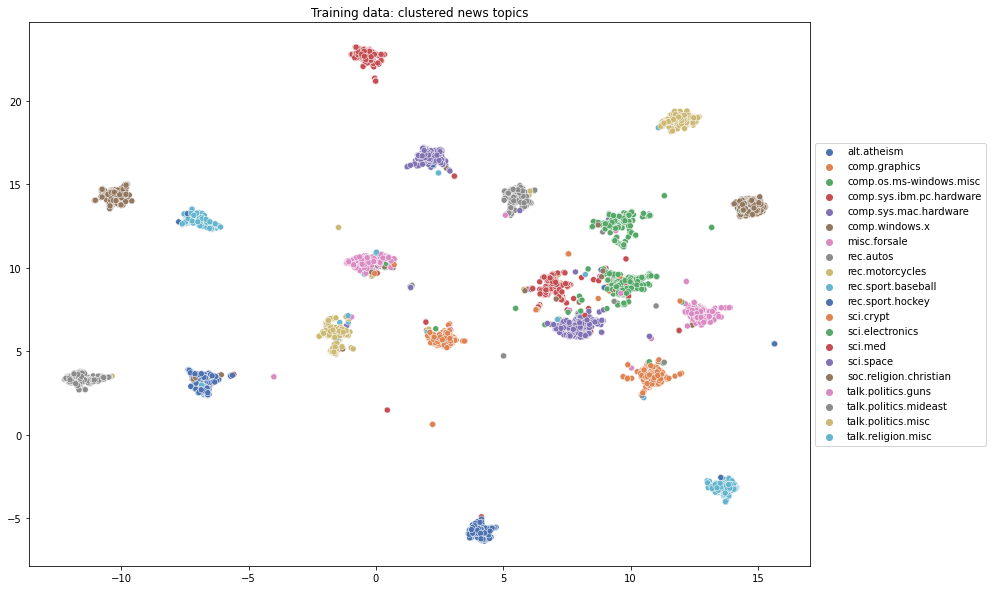

In [55]:
plot_clusters(dr_train, y_train, classes, title='Training data: clustered news topics')

### Training a classifier

First we train a classifier on a small subset of the data. The aim of the classifier is to predict the news topic of each instance.

Let's train our classifier. The classifier consists of a simple MLP head on top of a pre-trained SentenceTransformer model as the backbone. The SentenceTransformer remains frozen during training and only the MLP head is finetuned.

TODO - option to load already trained classifier (need to incorperate into prereq's too).

In [72]:
import numpy as np
from workshop_utilities import set_seed, split_data
set_seed(2022)  # This will ensure reproducibility (at least on CPU!)

In [73]:
classes

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [74]:
n_classes = len(classes)
n_train_c = [0] * n_classes
n_test_c = [0] * n_classes

n_train_c[5], n_train_c[11] = 200, 200  # 
n_test_c[5], n_test_c[11] = 100, 100  # 

(x_train, y_train), (x_test, y_test), _ = split_data(dataset.data, dataset.target, n_train_c, n_test_c, seed=0)

In [75]:
y_train

array([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11

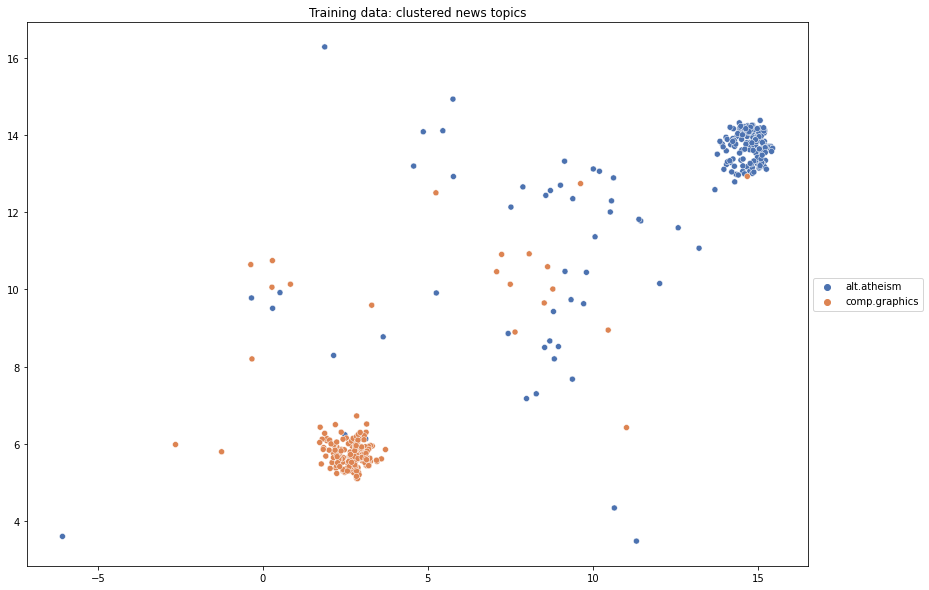

In [76]:
emb_train = emb_model(x_train)
plot_clusters(emb_train, y_train, classes, dr_model=umap_model, title='Training data: clustered news topics')

In [79]:
import torch
from workshop_utilities import Classifier, train_model, eval_model

TRAIN_CLF = False  # Set to TRUE to train classifier, otherwise it will be loaded from disk
filepath = 'models/classifier'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if TRAIN_CLF:
    # init model
    clf = Classifier().to(device)

    # Train model
    train_model(clf, x_train, y_train, epochs=5, shuffle=True)
    clf.eval()
    
    # Save model
    torch.save(clf.state_dict(), filepath)
else:
    # Load model
    clf = Classifier()
    clf.load_state_dict(torch.load(filepath))
    clf = clf.to(device)
    clf.eval()

_, _ = eval_model(clf, x_train, y_train, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.10it/s]

Accuracy: 0.958


### Testing the classifier

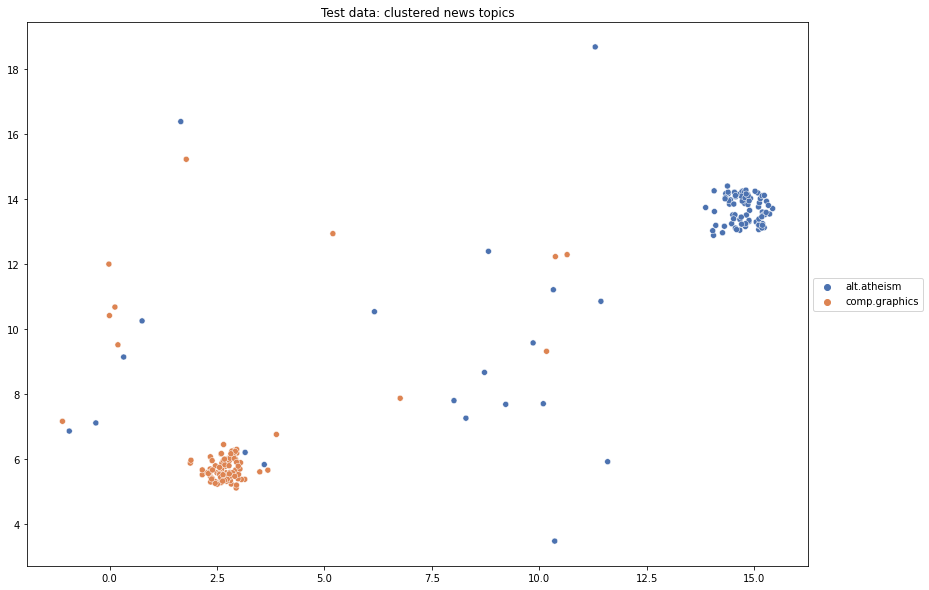

In [58]:
emb_test = emb_model(x_test)
plot_clusters(emb_test, y_test, classes, dr_model=umap_model, title='Test data: clustered news topics')

Test some classifier predictions

In [28]:
idx = 42
print(x_test[idx])

From: mek@hydrox.enet.dec.com (Mark Klamerus)
Subject: EventHandlers on XmPushButtons
X-Received: by usenet.pa.dec.com; id AA29453; Wed, 19 May 93 06:20:27 -0700
X-Received: by enet-gw.pa.dec.com; id AA05560; Wed, 19 May 93 06:20:22 -0700
X-Received: from hydrox.enet; by decwrl.enet; Wed, 19 May 93 06:20:22 PDT
X-To: comp.windows.x.usenet
X-Apparently-To: comp.windows.x.usenet
Lines: 22


	Help,

	I've got an applications with a series of pushbuttons across
	the top (a toolbar).  I wanted to add eventhandlers to these
	pushbuttons on EnterWindowMask and LeaveWindowMask so that
	I can put up some descriptive text about the function of each
	pushbutton as the pointer crosses over it.

	I've done this fine, but I've turned up the following problem:

	When the pushbuttons are sensitive I get callbacks on both of
	the above events, but when they are not sensitive I only get
	callbacks on LeaveWindow events.  This seems odd.  I would
	expect this to be an all-or-nothing type of thing.

	Is t

In [29]:
class_pred = clf([x_test[idx]]).argmax(1)
classes[class_pred]

'comp.windows.x'

In [30]:
idx = 42
print(x_test[idx])

From: mek@hydrox.enet.dec.com (Mark Klamerus)
Subject: EventHandlers on XmPushButtons
X-Received: by usenet.pa.dec.com; id AA29453; Wed, 19 May 93 06:20:27 -0700
X-Received: by enet-gw.pa.dec.com; id AA05560; Wed, 19 May 93 06:20:22 -0700
X-Received: from hydrox.enet; by decwrl.enet; Wed, 19 May 93 06:20:22 PDT
X-To: comp.windows.x.usenet
X-Apparently-To: comp.windows.x.usenet
Lines: 22


	Help,

	I've got an applications with a series of pushbuttons across
	the top (a toolbar).  I wanted to add eventhandlers to these
	pushbuttons on EnterWindowMask and LeaveWindowMask so that
	I can put up some descriptive text about the function of each
	pushbutton as the pointer crosses over it.

	I've done this fine, but I've turned up the following problem:

	When the pushbuttons are sensitive I get callbacks on both of
	the above events, but when they are not sensitive I only get
	callbacks on LeaveWindow events.  This seems odd.  I would
	expect this to be an all-or-nothing type of thing.

	Is t

In [31]:
class_pred = clf([x_test[idx]]).argmax(1)
classes[class_pred]

'comp.windows.x'

## 2. Detecting drift

### Introducing drift

Model uncertainty and supervised w/ FET

In [56]:
n_classes = len(classes)
n_nodrift_c = n_test_c
n_drift_c = [0] * n_classes

n_drift_c[5], n_drift_c[11], n_drift_c[14] = 100, 100, 100  # 

(x_nodrift, y_nodrift), (x_drift, y_drift), _ = split_data(dataset.data, dataset.target, n_nodrift_c, n_drift_c, seed=0)

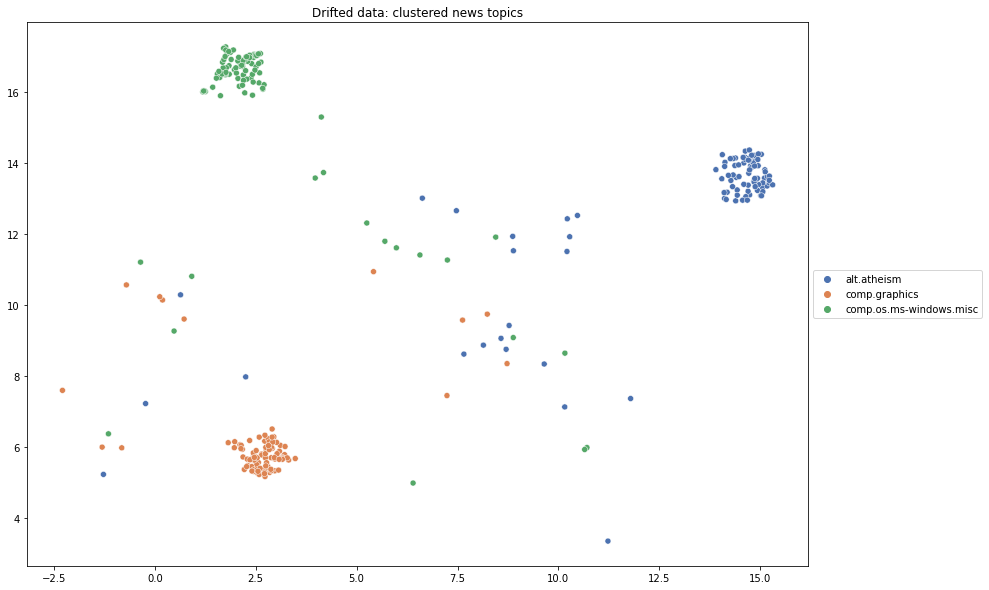

In [57]:
emb_drift = emb_model(x_drift)
plot_clusters(emb_drift, y_drift, classes, dr_model=umap_model, title='Drifted data: clustered news topics')

In [34]:
idx = np.unique(y_drift).astype(int)
np.array(classes)[idx]

array(['comp.windows.x', 'sci.crypt', 'sci.space'], dtype='<U24')

### Detecting model drift

If we have labels can monitor model performance directly...

In [35]:
_, _ = eval_model(clf, x_nodrift, y_nodrift)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.02s/it]

Accuracy: 0.965


In [36]:
_, _ = eval_model(clf, x_drift, y_drift)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]

Accuracy: 0.637


Otherwise we can use model uncertainty as a proxy

In [37]:
from alibi_detect.cd import ClassifierUncertaintyDrift

def preprocess_batch(x):
    return clf.embedding_model(x)

dd = ClassifierUncertaintyDrift(x_test, clf, 
                                preprocess_batch_fn=preprocess_batch, backend='pytorch', 
                                p_val=.05, preds_type='logits')

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


In [38]:
dd.predict(x_nodrift)

{'data': {'is_drift': 0,
  'distance': array([0.05], dtype=float32),
  'p_val': array([0.95321596], dtype=float32),
  'threshold': 0.05},
 'meta': {'name': 'ClassifierUncertaintyDrift',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.1'}}

In [39]:
dd.predict(x_drift)['data']

{'is_drift': 1,
 'distance': array([0.27333334], dtype=float32),
 'p_val': array([2.057099e-08], dtype=float32),
 'threshold': 0.05}

## 3. Detecting drift on the inputs

basic MMDDrift use

Use UMAP to viz drift.

In [40]:
def preprocess_fn(x):
    x = clf.embedding_model(x)
    return x.cpu().numpy()

In [41]:
from alibi_detect.cd import MMDDrift
dd = MMDDrift(x_test, backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.


No GPU detected, fall back on CPU.


In [42]:
dd.predict(x_nodrift)['data']

{'is_drift': 0,
 'distance': -0.0008933544158935547,
 'p_val': 0.9300000071525574,
 'threshold': 0.05,
 'distance_threshold': 0.0014798045}

In [43]:
dd.predict(x_drift)['data']

{'is_drift': 1,
 'distance': 0.008132100105285645,
 'p_val': 0.0,
 'threshold': 0.05,
 'distance_threshold': 0.00065362453}

## 4. Accounting for context

rgrgrhg

what happens if training 

###  Changing the relative subpopulation prevalence

relative frequency of one or more subpopulations (i.e. news topics) is changing in a way which can be attributed to external events. Importantly, the distribution underlying each subpopulation (e.g. the distribution of *hockey* news itself) remains unchanged, only its frequency changes.

In our example we assume that the World Series and Stanley Cup coincide on the calendar leading to a spike in news articles on respectively baseball and hockey. Furthermore, there is not too much news on Mac or Windows since there are no new releases or products planned anytime soon.

In [44]:
n_classes = len(classes)
n_nochange_c = 1000 // n_classes  # equally subsample each class from 1000 instances

n_change_c = [50] * n_classes  # 100 of each class (but then mod. below)
n_change_c[4], n_change_c[5] = 25, 25  # few stories on Mac/Windows
n_change_c[9], n_change_c[10] = 75, 75  # more stories on baseball/hockey

(x_nochange, y_nochange), (x_change, y_change), (x_held, y_held) = split_data(dataset.data, dataset.target, n_nochange_c, n_change_c, seed=0)

# Split remaining data into train/ref
idx_ref = np.random.choice(len(x_held), size=1000, replace=False)
x_ref, y_ref = [x_held[_] for _ in idx_ref], y_held[idx_ref]

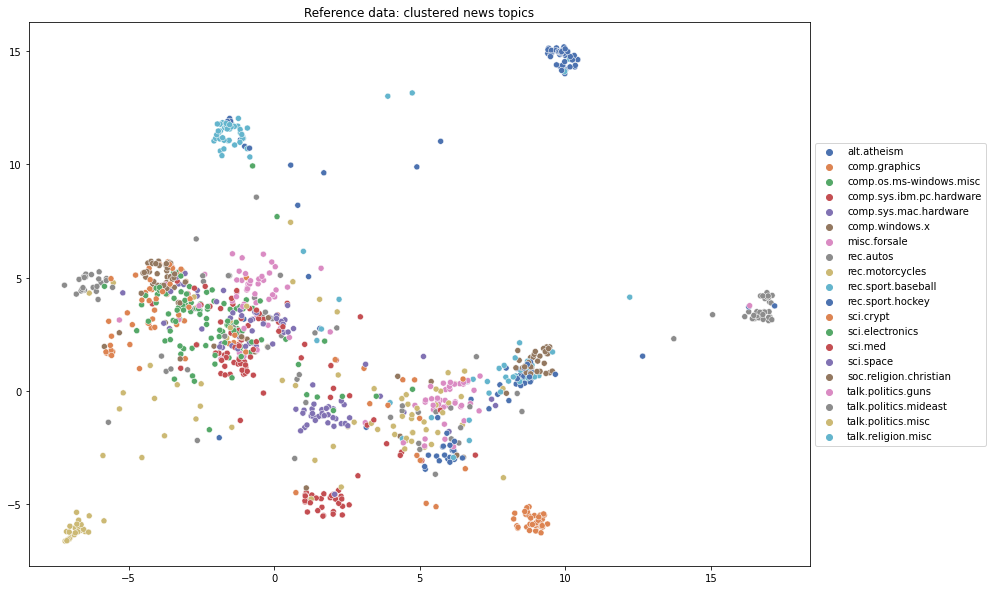

In [45]:
emb_ref = emb_model(x_ref)
plot_clusters(emb_ref, y_ref, classes, dr_model=umap_model, title='Reference data: clustered news topics')

### Vanilla MMD detector

In [46]:
dd = MMDDrift(x_ref, p_val=0.05, preprocess_fn=preprocess_fn)

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
2022-04-04 18:39:54.280786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ascillitoe/Documents/Work/Conferences/ODSC_East/example_notebook/venv/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-04 18:39:54.280816: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-04 18:39:54.280837: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AS-Seldon): /proc/driver/nvidia/version does not exist
2022-04-04 18:39:54.281083: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Ne

In [47]:
dd.predict(x_change)

{'data': {'is_drift': 1,
  'distance': 0.0006568432,
  'p_val': 0.0,
  'threshold': 0.05,
  'distance_threshold': 0.00016659498},
 'meta': {'name': 'MMDDriftTF',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.9.1',
  'backend': 'tensorflow'}}

The MMD detector consistently flags drift (low p-values). Note that this is the expected behaviour since the vanilla MMD detector cannot take any external context into account and correctly detects that the reference and test data do not follow the same underlying distribution.

However... not necesarilly drift we want to detect. Classifier should work fine on this data!


In [50]:
TRAIN_CLF = True  # Set to TRUE to train classifier, otherwise it will be loaded from disk
filepath = 'models/classifier_full'
if TRAIN_CLF:
    # init model
    clf_full = Classifier().to(device)

    # Train model
    train_model(clf_full, x_train, y_train, epochs=5, shuffle=True)
    clf_full.eval()
    
    # Save model
    torch.save(clf_full.state_dict(), filepath)
else:
    # Load model
    clf_full = Classifier()
    clf_full.load_state_dict(torch.load(filepath)).to(device)
    clf_full.eval()

_, _ = eval_model(clf_full, x_nochange, y_nochange)
_, _ = eval_model(clf_full, x_change, y_change)

 44%|████████████████████████████████████████████████████████████████▊                                                                                   | 14/32 [00:17<00:22,  1.23s/it]


KeyboardInterrupt: 

### Context aware MMD detector

We want to detect drift, given...

To achieve this we **condition on the prediction probabilities of the classifier we trained earlier to distinguish each of the 20 different news topics**. We can do this because the prediction probabilities can account for the frequency of occurrence of each of the topics (be it imperfectly given our classifier makes the occasional mistake).

In [87]:
def context(x):
    """ Condition on classifier prediction probabilities. """
    logits = clf(x)
    softmax_fn = torch.nn.Softmax(dim=-1)
    return softmax_fn(logits).detach().cpu().numpy()

In [ ]:
from alibi_detect.cd import ContextMMDDrift
dd_cad = ContextMMDDrift(x_ref, context(x_ref), p_val=.05, n_permutations=100, 
                         preprocess_fn=preprocess_fn, backend='pytorch')

In [ ]:
dd_cad.predict(x_change, context(x_change))

Hopefully drift isn't detected! (hint: it might be sometimes, as we expect a uniform distribution of p_val)

## Homework!

### Examining detector calibration

Before we set off our experiments, we compute all necessary embeddings and contexts so we don't have to run the embedding model on every loop. 

In [ ]:
n_exp = 5000  # This dataset is going to be split further in the loop, so it needs to be relatively large
idx = np.random.choice(n_all, size=n_exp, replace=False)
x_exp = [dataset.data[_] for _ in idx]

emb_exp, c_exp = emb_model(x_exp).cpu().numpy(), context(x_exp)

In [ ]:
from tqdm import tqdm

n_runs = 50  # number of drift detection runs, each with a different reference and test sample
n_ref, n_test = 1000, 500

p_vals_mmd, p_vals_cad = [], []
for _ in tqdm(range(n_runs)):
    
    # sample data
    idx = np.random.choice(n_exp, size=n_exp, replace=False)
    idx_ref, idx_test = idx[:n_ref], idx[n_ref:n_ref+n_test]
    emb_ref, c_ref = emb_exp[idx_ref], c_exp[idx_ref]
    emb_test, c_test = emb_exp[idx_test], c_exp[idx_test]
    
    # mmd drift detector
    dd_mmd = MMDDrift(emb_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_mmd = dd_mmd.predict(emb_test)
    p_vals_mmd.append(preds_mmd['data']['p_val'])
    
    # context-aware mmd drift detector 
    dd_cad = ContextMMDDrift(emb_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    preds_cad = dd_cad.predict(emb_test, c_test)
    p_vals_cad.append(preds_cad['data']['p_val'])
    
p_vals_mmd = np.array(p_vals_mmd)
p_vals_cad = np.array(p_vals_cad)

The below figure of the [Q-Q (Quantile-Quantile) plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) of a random sample from the uniform distribution *U[0,1]* against the obtained p-values from the vanilla and context-aware MMD detectors illustrate how well both detectors are calibrated. A perfectly calibrated detector should have a Q-Q plot which closely follows the diagonal. Only the middle plot in the grid shows the detector's p-values. The other plots correspond to *n_runs* p-values actually sampled from *U[0,1]* to contextualise how well the central plot follows the diagonal given the limited number of samples.

In [ ]:
from workshop_utilities import plot_qq
plot_qq(p_vals_mmd, 'Q-Q plot MMD detector')
plot_qq(p_vals_cad, 'Q-Q plot Context-Aware MMD detector')

As expected we can see that the context-aware MMD detectors is well-calibrated, but the normal MMD isn't!

The same can be seen using histogram's of p-value:

In [ ]:
from workshop_utilities import plot_hist
p_vals = [p_vals_mmd, p_vals_cad]
title = 'p-value distribution for a change in subpopulation prevalence'
plot_hist(p_vals, title)

Test power can be quantified in a similar way, but here we want to examine... see...

### Changing the subpopulation distribution

See https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_context_20newsgroup.html#Changing-the-subpopulation-distribution for an example where the distribution of the subpopulation has actually changed. In this case, we expect the context aware detector is expected to detect drift.

### Changing the context

See 

### Interpretability of detections